# Homework №3

This homework will be dedicated to Keyword Spotting (KWS), streaming and speedup NN.

# Data

In [ ]:
# import os
# datadir = "speech_commands"

# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# # alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
# !mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log

# samples_by_target = {
#     cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls)) if name.endswith('.wav')]
#     for cls in os.listdir(datadir)
#     if os.path.isdir(os.path.join(datadir, cls))
# }
# print('Classes:', ', '.join(sorted(samples_by_target.keys())[1:]))

In [ ]:
# samples_by_target

    Choose from 1 to 3 keywords to your liking, and use the rest as negative examples.
    We recommend to use sheila and/or marvin.

# Model

    In this homework assignment, you will need to implement a model for finding a keyword in a stream.

        1) https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf
            It is recommended to implement the version with CNN because it is easy and improves the model.

        2) What about streaming?
           This model works differently during training and inferance.
           During training you have some fixed input and you know that it has a keyword (or not).
           During the inferance, you read the T frames and make a prediction on them. And the next step is to read the T+1 frame,
           run the neural network just for it, and make a prediction based on it and the T-1 of the previous frames.
           This way you don't make unnecessary calculations.

           So, your model should support streaming mode.
           To demonstrate the work in streaming mode, take two random audio tracks of 10-20 seconds and glue them together
           so that your keyword will be between them. Run the model through this glued track and draw how the probability of your keyword changing over time.

        3) A good KWS is a robust KWS, so we ask you to implement as many augmentations as possible.
           (bonus) Download any noise from YouTube and add it as a background noise to the positive data. This helps a lot in real life.
           P.S. Use https://www.youtube-dl.org/

        4) (bonus) Add more attentions and orthogonality regularization. https://arxiv.org/abs/1910.04500
        
        5) (bonus) Speedup you model! Implement distillation of your model, for example,
            train the LSTM with 256 hidden size and distil it into LSTM with 128 hidden size.

# Code

    1) In this homework you are allowed to use pytorch-lighting.

    2) Try to write code more structurally and cleanly!
    
    3) Good logging of experiments save your nerves and time, so we ask you to use W&B. Log loss, FA/FR rate or something else.
        Do not remove the logs until we have checked your work and given you a grade!
    
    4) (Bonus) We also ask you to organize your code in github repo with Docker and setup.py. You can use my template https://github.com/markovka17/dl-start-pack.
    
    5) Your work must be reproducable, so fix seed, save the weights of model, and etc.
    
    6) In the end of your work write inference utils. Anyone should be able to take your weight, load it into the model and run it on some audio track.

In [ ]:
!pip install pytorch-lightning
!pip install --upgrade wandb -qq
!pip install torchaudio==0.6.0
!pip install audiomentations

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch import nn
import torch
import torch.nn.functional as F
import os
import sys
import torchaudio
import numpy as np

In [ ]:
from torch.utils.data.dataloader import default_collate

def no_pad_collate(batch):
    keys = batch[0].keys()
    collated_batch = {key: [] for key in keys}
    for key in keys:
        items = [item[key] for item in batch]
        collated_batch[key] = items
    return collated_batch

class CommandsDataset(torch.utils.data.Dataset):
    def __init__(
          self, train=True, transforms=None, 
          targets=['marvin', 'sheila'], download=True, 
          datadir="speech_commands"
        ):
        if download:
            os.system("wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz")
            # alternative url: https://www.dropbox.com/s/j95n278g48bcbta/speech_commands_v0.01.tar.gz?dl=1
            os.system(f"mkdir {datadir} && tar -C {datadir} -xvzf speech_commands_v0.01.tar.gz 1> log")
        self.samples_by_target = {
            cls: [os.path.join(datadir, cls, name) for name in os.listdir("./speech_commands/{}".format(cls)) if name.endswith('.wav')]
            for cls in os.listdir(datadir)
            if os.path.isdir(os.path.join(datadir, cls))
        }
        self.train = train
        self.transforms = transforms
        self.target2id = {target: i for i, target in enumerate(targets)}
        self.id2target = {i: target for target, i in self.target2id.items()}

        if self.train:
            self.samples_by_target = {
                cls: audios[:int(0.75 * len(audios))] for cls, audios in self.samples_by_target.items()
            }
        else:
            self.samples_by_target = {
                cls: audios[int(0.75 * len(audios)):] for cls, audios in self.samples_by_target.items()
            }
        self.samples = []
        for cls, audios in self.samples_by_target.items():
            for audio in audios:
                self.samples.append((audio, self.target2id.get(cls, -1) + 1))


    def __len__(self):
        return len(self.samples)


    def __getitem__(self, idx):
        file_audio, target_id = self.samples[idx]
      
        # Load audio
        waveform, sample_rate = torchaudio.load(file_audio)
        if self.transforms is not None:
            return self.transforms({'audio' : waveform, 'sample_rate': sample_rate, 'target': target_id})
        return {'audio' : waveform, 'sample_rate': sample_rate, 'target': target_id}

In [ ]:
# transforms

from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
import random

class Compose(object):
    """Composes several transforms together."""

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for t in self.transforms:
            try:
              data = t(data)
            except TypeError:
              # audiomentation transform
              data['audio'] = t(data['audio'], sample_rate=data['sample_rate'])
        return data


class AudioSqueeze:
    def __call__(self, data):
        data['audio'] = data['audio'].squeeze(0)
        return data

class AddLengths:
    def __call__(self, data):
        data['lengths'] = torch.tensor([item.shape[-1] for item in data['audio']]).to(data['audio'][0].device)
        return data

class ToGpu:
    def __init__(self, device, batched=True):
        self.device = device
        self.batched = batched

    def __call__(self, data):
        if self.batched:
            data = {k: [torch.from_numpy(np.array(item)).to(self.device) for item in v] for k, v in data.items()}
        else:
            data = {k: torch.from_numpy(np.array(v)).to(self.device) for k, v in data.items()}
        return data

class ToNumpy:
    """
    Transform to make numpy array
    """
    def __call__(self, data):
        for key in data:
            data[key] = np.array(data[key])
        return data


class Pad:
    def __call__(self, data):
        padded_batch = {}
        for k, v in data.items():
            if len(v[0].shape) < 2:
                items = [item[..., None] for item in v]
                padded_batch[k] = torch.nn.utils.rnn.pad_sequence(items, batch_first=True)[..., 0]
            else:
                items = [item.permute(1, 0) for item in v]
                padded_batch[k] = torch.nn.utils.rnn.pad_sequence(items, batch_first=True).permute(0, 2, 1)
        return padded_batch


class NormalizedMelSpectrogram(torchaudio.transforms.MelSpectrogram):
    def __init__(self, normalize=None, batched=True, *args, **kwargs):
        super(NormalizedMelSpectrogram, self).__init__(*args, **kwargs)
        self.batched = batched
        if normalize == 'to05':
            self.normalize = Normalize([0.5], [0.5])
        elif normalize == 'touniform':
            self.normalize = lambda x: (x - torch.mean(x, dim=-1, keepdim=True)) / (torch.std(x, dim=-1, keepdim=True) + 1e-18)
        else:
            self.normalize = None


    def forward(self, data):
        if self.batched:
            for i in range(len(data['audio'])):
                melsec = super(NormalizedMelSpectrogram, self).forward(data['audio'][i])
                if self.normalize is not None:
                    logmelsec = torch.log(torch.clamp(melsec, min=1e-18))
                    melsec = self.normalize(logmelsec[None])[0]
                data['audio'][i] = melsec
        else:
            melsec = super(NormalizedMelSpectrogram, self).forward(data['audio'])
            if self.normalize is not None:
                logmelsec = torch.log(torch.clamp(melsec, min=1e-18))
                melsec = self.normalize(logmelsec[None])[0]
            data['audio'] = melsec
        return data


class MaskSpectrogram(object):
    """Masking a spectrogram aka SpecAugment."""

    def __init__(self, frequency_mask_max_percentage=0.3, time_mask_max_percentage=0.1, probability=1.0):
        self.frequency_mask_probability = frequency_mask_max_percentage
        self.time_mask_probability = time_mask_max_percentage
        self.probability = probability

    def __call__(self, data):
        for i in range(len(data['audio'])):
            if random.random() < self.probability:
                nu, tau = data['audio'][i].shape

                f = random.randint(0, int(self.frequency_mask_probability*nu))
                f0 = random.randint(0, nu - f)
                data['audio'][i][f0:f0 + f, :] = 0

                t = random.randint(0, int(self.time_mask_probability*tau))
                t0 = random.randint(0, tau - t)
                data['audio'][i][:, t0:t0 + t] = 0

        return data

In [ ]:
# model:

class CRNNEncoder(nn.Module):
    def __init__(
        self,
        in_channels,
        cnn_layers=2,
        rnn_layers=2,
        hidden_size=16,
        kernel_size=9,
        dropout=0.2
    ):
      super(CRNNEncoder, self).__init__()
      self.kernel_size = kernel_size
      self.cnn_layers = cnn_layers

      prev_channels = in_channels
      channels = hidden_size * 25 if cnn_layers > 0 else None 
      layers = []
      for _ in range(cnn_layers):
          layers.append(nn.Conv1d(
              prev_channels, channels, kernel_size=kernel_size, 
              padding=(kernel_size - 1) // 2, bias=False
          ))
          layers.append(nn.BatchNorm1d(channels))
          layers.append(nn.ReLU())
          prev_channels = channels
        
      self.cnn_net = nn.Sequential(
          *layers
      ) if len(layers) > 0 else None

      self.rnn = nn.GRU(
          input_size=prev_channels, 
          hidden_size=hidden_size, 
          num_layers=rnn_layers, 
          dropout=dropout, 
          batch_first=True
      )

    
    def forward(
        self,
        input,
        last_h=None
    ):
      # input (batch_size, max_length, hidden_size)
      if last_h is None:
          if self.cnn_net is not None:
              input = self.cnn_net(input.permute(0, 2, 1)).permute(0, 2, 1)
          output, h = self.rnn(input)
          return output, h
      # streaming mode:
      part_input = input[:, -self.kernel_size * self.cnn_layers:]
      if self.cnn_net is not None:
            part_input = self.cnn_net(part_input.permute(0, 2, 1)).permute(0, 2, 1)
      output, h = self.rnn(part_input[:, [-1]], last_h)
      return output, h


class AttentionNet(nn.Module):
    def __init__(
        self,
        net,
        hidden_size,
        num_classes,
        streaming_mode=False
    ):
        super(AttentionNet, self).__init__()
        self.hidden_size = hidden_size
        self.streaming_mode = streaming_mode
        self.last_h = None

        self.net = net
        self.W_mem2hidden = nn.Linear(hidden_size, hidden_size)
        self.v = nn.Linear(hidden_size, 1)
        self.w_global = nn.Linear(hidden_size, num_classes)

    def forward(
        self,
        input,
        length
    ):
        input = input.permute(0, 2, 1)
        # input (batch_size, max_length, hidden_size)
        # length (batch_size, )
        if self.streaming_mode:
            if self.last_h is not None:
                temp_out, self.last_h = self.net(input, self.last_h)
                out = torch.cat([self.prev_out[:, 1:], temp_out], dim=1)
            else:
                out, self.last_h = self.net(input)
            self.prev_out = out
        else:
            out, _ = self.net(input) # (batch_size, max_length, hidden_size)


        batch_size = out.size(0)
        max_length = out.size(1)

        # mask (batch_size, max_length)
        mask = torch.arange(max_length, device=length.device,
                        dtype=length.dtype)[None, :] < length[:, None]

        # if out.shape[1] > 0:
        scores = self.W_mem2hidden(out)
        scores = torch.tanh(scores)
        scores = self.v(scores).squeeze(2) # (batch_size, max_length)
        scores = scores.masked_fill(mask, -1e20) # (batch_size, max_length)
        attn_weights = F.softmax(scores, dim=1) # (batch_size, max_length)
        attn_weights = attn_weights.unsqueeze(1) # (batch_size, 1,  max_length)
        context = torch.matmul(attn_weights, out).squeeze(1) # (batch_size, hidden_size)

        w_t = self.w_global(context)
        return w_t

In [ ]:
class KWSModel(pl.LightningModule):
    def __init__(
           self, 
           model, 
           lr,
           in_channels,
           batch_size
        ):
        super(KWSModel, self).__init__()
        self.model = model
        self.lr = lr
        self.batch_size = batch_size
        self.mel_spectrogramer_train = Compose([
            ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
            NormalizedMelSpectrogram(
                sample_rate=16000,
                n_mels=in_channels,
                normalize='touniform'
            ).to('cuda' if torch.cuda.is_available() else 'cpu'),
            MaskSpectrogram(
                frequency_mask_max_percentage=0.2, 
                time_mask_max_percentage=0.1, 
                probability=1.0
            ),
            AddLengths(),
            Pad()
        ])
        self.mel_spectrogramer_val = Compose([
            ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
            NormalizedMelSpectrogram(
                sample_rate=16000,
                n_mels=in_channels,
                normalize='touniform'
            ).to('cuda' if torch.cuda.is_available() else 'cpu'),
            AddLengths(),
            Pad()
        ])

    def forward(self, batch):
        return self.model(batch['audio'], batch['lengths'])
    
    def training_step(self, batch, batch_nb):
        # REQUIRED
        batch = self.mel_spectrogramer_train(batch)
        y_hat = self(batch)
        y = batch['target']
        loss = F.cross_entropy(y_hat, y)
        y_pred = F.softmax(y_hat, dim=1).argmax(dim=1)
        acc = (y_pred == y).float().mean()
        fa = torch.bitwise_and(y_pred != y, y == 0).float().sum()
        fr = torch.bitwise_and(y_pred != y, y != 0).float().sum()
        length_zeros = batch['lengths'][y == 0].sum()
        length_nonzeros = batch['lengths'][y != 0].sum()

        self.logger.experiment.log({
            'train_loss': loss, 'train_acc': acc, 
            'train_fa': fa / (y == 0).float().sum(), 'train_fr': fr / (y != 0).float().sum(),
            'train_fa_per_len': fa / length_zeros, 'train_fr_per_len': fr / length_nonzeros
        })
        return {'train_loss': loss, 'train_acc': acc}


    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        batch = self.mel_spectrogramer_val(batch)
        y_hat = self(batch)
        y = batch['target']
        loss = F.cross_entropy(y_hat, y)
        y_pred = F.softmax(y_hat, dim=1).argmax(dim=1)
        acc = (y_pred == y).float().mean()
        fa = torch.bitwise_and(y_pred != y, y == 0).float().sum()
        fr = torch.bitwise_and(y_pred != y, y != 0).float().sum()
        length_zeros = batch['lengths'][y == 0].sum()
        length_nonzeros = batch['lengths'][y != 0].sum()
        return {
            'val_loss': loss, 'val_acc': acc, 'fa': fa, 'fr': fr, 
            'length_zeros': length_zeros, 'length_nonzeros': length_nonzeros,
            'zeros': (y == 0).float().sum(), 'non_zeros': (y != 0).float().sum()
        }

    def validation_epoch_end(self, outputs):
        # outputs is an array with what you returned in validation_step for each batch
        # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}]
        
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        avg_fa = torch.stack([x['fa'] for x in outputs]).sum() / torch.stack([x['zeros'] for x in outputs]).sum()
        avg_fr = torch.stack([x['fr'] for x in outputs]).sum() / torch.stack([x['non_zeros'] for x in outputs]).sum()

        avg_fa_per_len = torch.stack([x['fa'] for x in outputs]).sum() / torch.stack([x['length_zeros'] for x in outputs]).sum()
        avg_fr_per_len = torch.stack([x['fr'] for x in outputs]).sum() / torch.stack([x['length_nonzeros'] for x in outputs]).sum()

        self.logger.experiment.log({
            'avg_val_loss': avg_loss, 'avg_val_acc': avg_acc,
            'avg_val_fa': avg_fa, 'avg_val_fr': avg_fr,
            'avg_val_fa_per_len': avg_fa_per_len, 'avg_val_fr_per_len': avg_fr_per_len
        })

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    # dataset:

    def prepare_data(self):
        CommandsDataset(train=True, download=True)

    def train_dataloader(self):
        train_transforms = Compose([
            ToNumpy(),
            AudioSqueeze(),
            AddGaussianNoise(
                min_amplitude=0.001,
                max_amplitude=0.015,
                p=0.5
            ),
            TimeStretch(
                min_rate=0.8,
                max_rate=1.25,
                p=0.5
            ),
            PitchShift(
                min_semitones=-4,
                max_semitones=4,
                p=0.5
            )
        ])
        dataset_train = CommandsDataset(train=True, download=False, transforms=train_transforms)
        dataset_train = torch.utils.data.DataLoader(dataset_train, 
                              batch_size=self.batch_size, collate_fn=no_pad_collate, shuffle=True, num_workers=4)
        return dataset_train
      
    def val_dataloader(self):
        dataset_val = CommandsDataset(train=False, download=False, transforms=Compose([ToNumpy(), AudioSqueeze()]))
        dataset_val = torch.utils.data.DataLoader(dataset_val, 
                              batch_size=self.batch_size, collate_fn=no_pad_collate, num_workers=4)
        return dataset_val


In [ ]:
def fix_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.deterministic = True

fix_seeds(seed=42)

In [ ]:
crnn = CRNNEncoder(
    in_channels=42,
    hidden_size=16, 
    dropout=0.1,
    cnn_layers=2,
    rnn_layers=2,
    kernel_size=9
)
model = AttentionNet(
    crnn, hidden_size=16, num_classes=3
)
pl_model = KWSModel(model, lr=4e-5, in_channels=42, batch_size=32)

In [ ]:
wandb_logger = WandbLogger(name='final_kiss',project='kws-attention', log_model=True)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
trainer = pl.Trainer(max_epochs=15, logger=wandb_logger, gpus=1)   
trainer.fit(pl_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: oleges (use `wandb login --relogin` to force relogin)



  | Name  | Type         | Params
---------------------------------------
0 | model | AttentionNet | 1 M   


wandb: WARNING Symlinked 0 file into the W&B run directory, call wandb.save again to sync new files.


1

In [ ]:
# trainer.run_evaluation(test_mode=False)

In [ ]:
# run in streaming mode:
def run_streaming_on_file(file_audio, T):
    model.streaming_mode = True
    model.last_h = None
    model.cuda()

    waveform, sample_rate = torchaudio.load(file_audio)
    data_transforms = Compose([
        ToNumpy(),
        AudioSqueeze(),
        ToGpu(device='cuda' if torch.cuda.is_available() else 'cpu', batched=False),
        NormalizedMelSpectrogram(
            sample_rate=16000,
            n_mels=42,
            normalize='touniform',
            batched=False
        ).to('cuda' if torch.cuda.is_available() else 'cpu')
    ])
    data = data_transforms({'audio' : waveform, 'sample_rate': sample_rate})
    melspec = data['audio'][None]
    preds = []
    for indx in range(melspec.shape[-1] - T):
        slice_melspec = melspec[..., indx:indx+T]
        with torch.no_grad():
            raw_probs = model(slice_melspec, torch.tensor([T]).to('cuda' if torch.cuda.is_available() else 'cpu'))
            y_pred = F.softmax(raw_probs, dim=1).cpu().numpy()
        preds.append(y_pred)
    return np.array(preds)

In [ ]:
import matplotlib.pyplot as plt

def visualize(preds):
  for id, label in zip([1, 2], ['marvin', 'sheila']):
      plt.plot(preds[:, 0, id], label=label)

  plt.xlabel('time')
  plt.ylabel('prob')
  plt.legend()
  plt.show()

Let's see how works background noize.

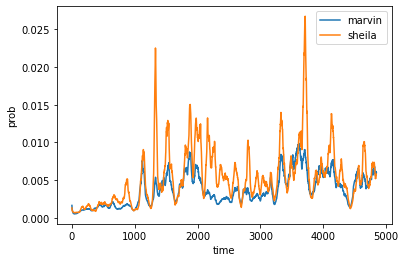

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/_background_noise_/running_tap.wav', T = 50)
visualize(preds)

Seems good, what about marvin class?

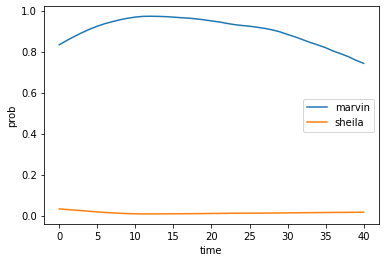

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/marvin/460f2bad_nohash_0.wav', T = 40)
visualize(preds)

Nice. Let's check smaller $T$ - chunk size. We can notice that for smaller T name cannot be recognized.

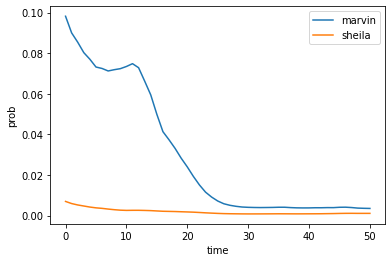

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/marvin/460f2bad_nohash_0.wav', T = 30)
visualize(preds)

Okay, the same for Sheila:

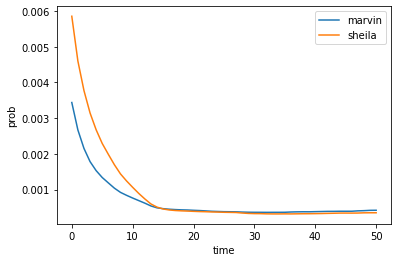

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/sheila/5588c7e6_nohash_0.wav', T = 30)
visualize(preds)

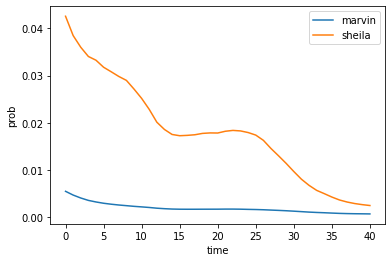

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/sheila/5588c7e6_nohash_0.wav', T = 40)
visualize(preds)

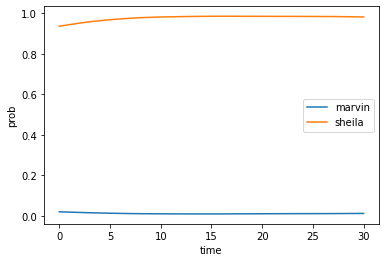

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/sheila/5588c7e6_nohash_0.wav', T = 50)
visualize(preds)

Nice. Seven should be similar to sheila, let's check how it works.

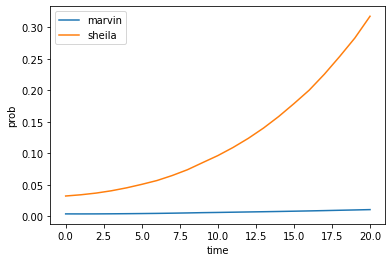

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/seven/b1114e4f_nohash_0.wav', T = 60)
visualize(preds)

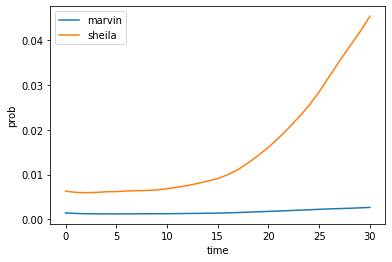

In [ ]:
preds = run_streaming_on_file(file_audio = 'speech_commands/seven/b1114e4f_nohash_0.wav', T = 50)
visualize(preds)

Okay...
This model is not perfect, but probability is smaller, then for background. Hard mining should help in this case.